In [4]:
# import os
# from PIL import Image
# import numpy as np
# import torch
# from torch.utils.data import Dataset
# from torchvision import transforms

# # Mapowanie kolorów RGB → klasy
# COLOR_MAP = {
#     (0, 0, 0): 0,           # tło
#     (255, 0, 0): 1,         # łuk
#     (173, 255, 47): 2,      # spoina
#     (0, 191, 255): 3        # kolumna ciepła
# }

# def mask_to_class(mask_img, tolerance=5):
#     """Zamień maskę RGB na klasową z tolerancją koloru"""
#     mask_array = np.array(mask_img)
#     class_mask = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.uint8)

#     for rgb, cls in COLOR_MAP.items():
#         # Oblicz różnicę między każdym pikselem a docelowym kolorem
#         diff = np.abs(mask_array - np.array(rgb))
#         match = np.all(diff <= tolerance, axis=-1)
#         class_mask[match] = cls

#     return class_mask

# class ThermalSegmentationDataset(Dataset):
#     def __init__(self, image_dir, mask_dir, image_size=(256, 256), transform=None):
#         self.image_dir = image_dir
#         self.mask_dir = mask_dir
#         self.image_size = image_size
#         self.transform = transform
#         self.filenames = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])

#     def __len__(self):
#         return len(self.filenames)

#     def __getitem__(self, idx):
#         image_name = self.filenames[idx]
#         mask_name = image_name.replace(".jpg", "_mask.png")

#         # Ścieżki
#         image_path = os.path.join(self.image_dir, image_name)
#         mask_path = os.path.join(self.mask_dir, mask_name)

#         # Wczytaj i przeskaluj
#         image = Image.open(image_path).convert("L").resize(self.image_size)
#         mask = Image.open(mask_path).convert("RGB").resize(self.image_size)

#         # Przetwarzanie
#         if self.transform:
#             image = self.transform(image)
#         else:
#             image = transforms.ToTensor()(image)

#         mask_class = mask_to_class(mask)
#         mask_tensor = torch.from_numpy(mask_class).long()

#         return image, mask_tensor, image_name


In [9]:
from PIL import Image
import numpy as np

def print_unique_colors(mask_path):
    mask = Image.open(mask_path).convert("RGB")
    mask_array = np.array(mask)
    pixels = mask_array.reshape(-1, 3)
    unique_colors = np.unique(pixels, axis=0)
    print("Unikalne kolory w masce:")
    for color in unique_colors:
        print(tuple(color))


In [ ]:
print_unique_colors("data/masks/frame_002386_mask.png")

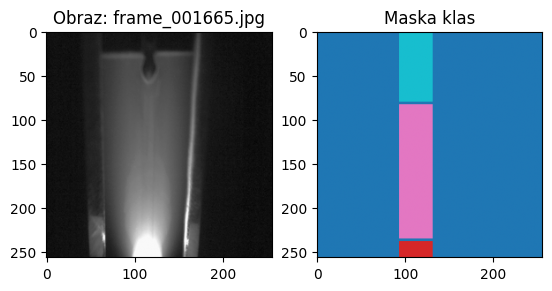

In [6]:
from dataset import ThermalSegmentationDataset
import matplotlib.pyplot as plt

dataset = ThermalSegmentationDataset("data/images", "data/masks", image_size=(256, 256))

# Sprawdzenie jednego przykładu
img, mask, name = dataset[2]

plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"Obraz: {name}")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="tab10")
plt.title("Maska klas")
plt.show()


In [7]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=4):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

        def up_block(in_c, out_c):
            return nn.Sequential(
                nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.up4 = up_block(1024, 512)
        self.dec4 = conv_block(1024, 512)
        self.up3 = up_block(512, 256)
        self.dec3 = conv_block(512, 256)
        self.up2 = up_block(256, 128)
        self.dec2 = conv_block(256, 128)
        self.up1 = up_block(128, 64)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        b = self.bottleneck(self.pool4(e4))

        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final(d1)


In [14]:
from torch.utils.data import random_split, DataLoader

# Parametry
# BATCH_SIZE = 4
# VAL_SPLIT = 0.2

# # Podział na train/val
# val_size = int(len(dataset) * VAL_SPLIT)
# train_size = len(dataset) - val_size
# train_ds, val_ds = random_split(dataset, [train_size, val_size])

# # Loadery
# train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)


dataset = ThermalSegmentationDataset("data/images", "data/masks", image_size=(256, 256))

# 80% trening, 20% walidacja
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [15]:
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = UNet(in_channels=1, out_channels=4).to(DEVICE)  # 4 klasy: tło, łuk, spoina, kolumna ciepła
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()


In [22]:
NUM_EPOCHS = 50

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for images, masks, _ in train_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Walidacja
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks, _ in val_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


torch.save(model.state_dict(), "unet_segment_model.pth")


Epoch 1/50 | Train Loss: 0.3457 | Val Loss: 0.7832
Epoch 2/50 | Train Loss: 0.3457 | Val Loss: 0.7832
Epoch 3/50 | Train Loss: 0.3457 | Val Loss: 0.7832
Epoch 4/50 | Train Loss: 0.3457 | Val Loss: 0.7832
Epoch 5/50 | Train Loss: 0.3457 | Val Loss: 0.7832
Epoch 6/50 | Train Loss: 0.3457 | Val Loss: 0.7832
Epoch 7/50 | Train Loss: 0.3457 | Val Loss: 0.7832
Epoch 8/50 | Train Loss: 0.3457 | Val Loss: 0.7832
Epoch 9/50 | Train Loss: 0.3457 | Val Loss: 0.7832
Epoch 10/50 | Train Loss: 0.3457 | Val Loss: 0.7832
Epoch 11/50 | Train Loss: 0.3457 | Val Loss: 0.7832
Epoch 12/50 | Train Loss: 0.3457 | Val Loss: 0.7832
Epoch 13/50 | Train Loss: 0.3457 | Val Loss: 0.7832
Epoch 14/50 | Train Loss: 0.3457 | Val Loss: 0.7832
Epoch 15/50 | Train Loss: 0.3457 | Val Loss: 0.7832
Epoch 16/50 | Train Loss: 0.3457 | Val Loss: 0.7832
Epoch 17/50 | Train Loss: 0.3457 | Val Loss: 0.7832
Epoch 18/50 | Train Loss: 0.3457 | Val Loss: 0.7832
Epoch 19/50 | Train Loss: 0.3457 | Val Loss: 0.7832
Epoch 20/50 | Train L

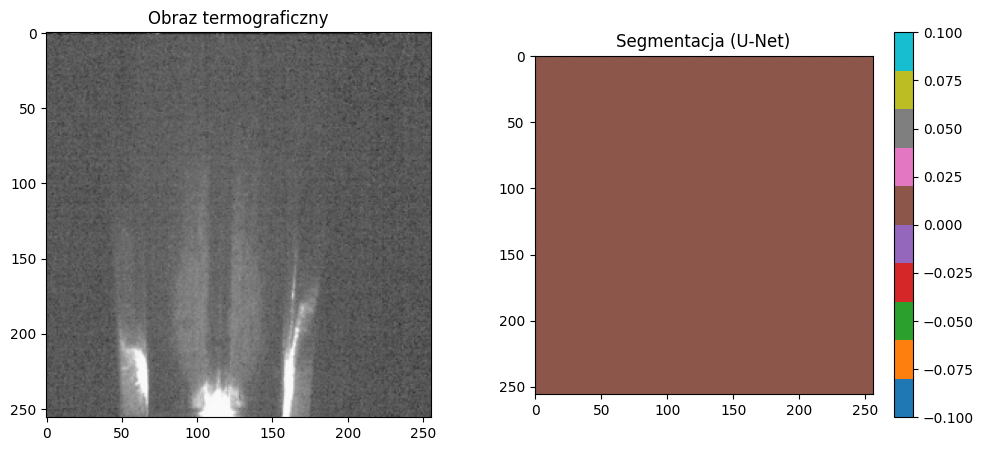

torch.Size([1, 4, 256, 256])


In [21]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision import transforms
from dataset import mask_to_class  # jeśli chcesz porównać z rzeczywistą maską


seq_file_name = "600_41n20_1_2mm_-161_08_05_51_044"  # <- podmień na swoją sekwencję
image_file = "frame_000299"  # <- podmień na swój obraz
# --- ŚCIEŻKA DO OBRAZU ---
test_image_path = f"frames_output/{seq_file_name}/preview_fixed/{image_file}.jpg"  # <- podmień na swój obraz

# --- WCZYTANIE I PRZYGOTOWANIE OBRAZU ---
image = Image.open(test_image_path).convert("L").resize((256, 256))
input_tensor = transforms.ToTensor()(image).unsqueeze(0).to(DEVICE)  # (1, 1, 256, 256)

# --- WCZYTANIE MODELU ---
model = UNet(in_channels=1, out_channels=4).to(DEVICE)
model.load_state_dict(torch.load("unet_segment_model.pth"))
model.eval()

# --- PREDYKCJA ---
with torch.no_grad():
    output = model(input_tensor)
    predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

# --- WIZUALIZACJA ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Obraz termograficzny")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap="tab10")  # tab10 daje ładne kolory dla klas
plt.title("Segmentacja (U-Net)")
plt.colorbar()
plt.show()

print(output.shape)


In [20]:
print(output.shape)
unique_classes = np.unique(predicted_mask)
print("Unikalne klasy w masce predykcji:", unique_classes)


torch.Size([1, 4, 256, 256])
Unikalne klasy w masce predykcji: [0]
